In [59]:
import rclpy
from rosbag2_py import StorageOptions, ConverterOptions, SequentialReader
from rclpy.serialization import deserialize_message
from sensor_msgs.msg import LaserScan
from tf2_msgs.msg import TFMessage
import tf2_ros
import tf_transformations
from tf_transformations import euler_from_quaternion
from geometry_msgs.msg import Quaternion

import numpy as np
import matplotlib.pyplot as plt

In [60]:
#Load the data


from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore

# Create a typestore and get the string class.
typestore = get_typestore(Stores.LATEST)

# Define the path to your bag file
bag_path = '/home/osama/ros2_amr/src/bagfile/bagfile'

# Create reader instance and open for reading.
with Reader(bag_path) as reader:
    # Topic and msgtype information is available on .connections list.
    for connection in reader.connections:
        print(f"Topic: {connection.topic}, Message Type: {connection.msgtype}")

    # Iterate over messages for all topics
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/scan':
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            # print(f"/scan data: {msg}")

        elif connection.topic == '/tf':
                msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
                # print(f"/tf data: {msg}")

        elif connection.topic == '/tf_static':
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            # print(f"/tf_static data: {msg}")

Topic: /scan, Message Type: sensor_msgs/msg/LaserScan
Topic: /tf, Message Type: tf2_msgs/msg/TFMessage
Topic: /tf_static, Message Type: tf2_msgs/msg/TFMessage


Task 2: Cartesian Representation of Data [30 points]
You have to convert the scan data from polar coordinates to cartesian coordinates for better interpretation and integration with other functionalities. For this, you need to get the minimum and maximum angular range of the laser scanner and also the resolution of angles (which gives you the number of data points in a single scan).

Note: You need to figure out how can you get these details from scan_data. Also, it might interest you to know with respect to which frame the data was published.

In [ ]:
## Helper function to convert scan data from polar to Cartesian coordinates
def np_polar2cart(np_polar: np.ndarray):
    """

    Keyword arguments:
    np_polar: np.ndarray -- A 2D numpy array, where each row represents the distance to an obstacle at a 
                            corresponding angle in radians. Thus, the number of rows will be equal to
                            the number of scan data points

    Return:
    np_cart: np.ndarray -- A 2D numpy array, where each row consists of X and Y Cartesian coordinates
                           of an obstacle
    """
    # Extract the distance and angle data from the input array
    dist = np_polar[:, 0]
    angle = np_polar[:, 1]

    # Convert polar coordinates to Cartesian coordinates
    x = dist * np.cos(angle)
    y = dist * np.sin(angle)

    # Stack the X and Y coordinates to form a 2D array
    np_cart = np.column_stack((x, y))

    return np_cart

# YOUR CODE HERE
# Iterate over messages for all topics
with Reader(bag_path) as reader:
    # Iterate over messages for the /scan topic
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/scan':
            # Deserialize the LaserScan message
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            frame_id = msg.header.frame_id
            # print(f"Data published with respect to frame: {frame_id}")
        
            # Extract ranges and angle information
            ranges = np.array(msg.ranges)  # Distance values
            angles = np.linspace(msg.angle_min, msg.angle_max, len(ranges))  # Generate angle array            
            # Combine ranges and angles into a 2D numpy array
            np_polar = np.column_stack((ranges, angles))
            # print(np_polar)
            


Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: base_laser_front_link
Data published with respect to frame: ba

2
(150, 2)


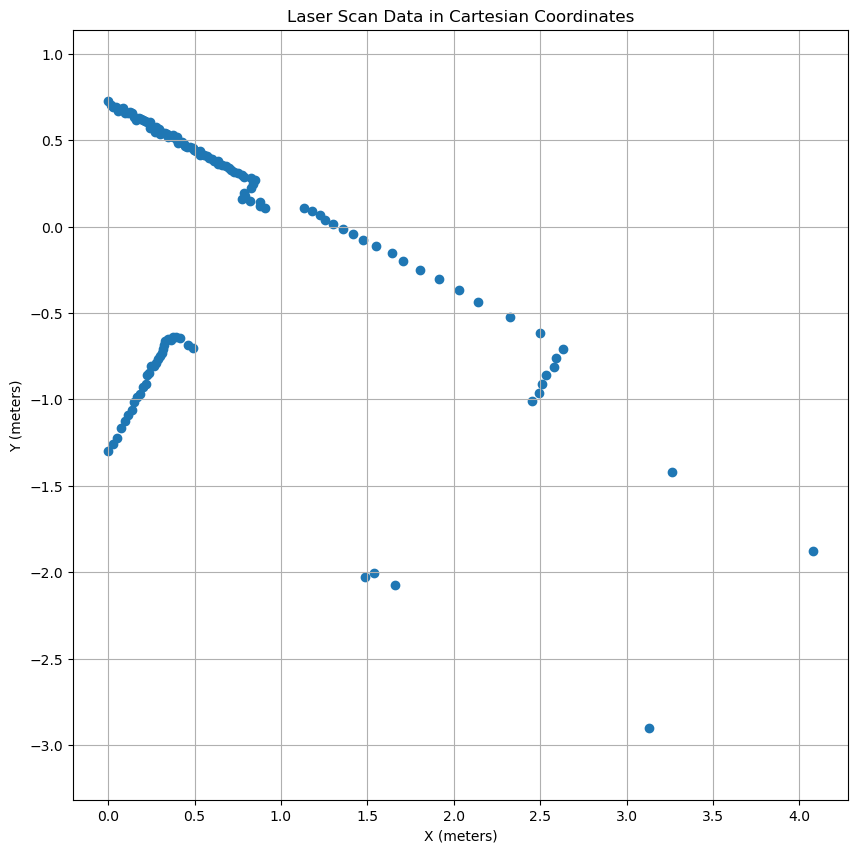

In [62]:
#plotting catessian coordinates

# Convert polar coordinates to Cartesian coordinates
np_cart = np_polar2cart(np_polar)
print(np_cart.ndim)
print(np_cart.shape)
# Plot the Cartesian coordinates
plt.figure(figsize=(10, 10))
plt.scatter(np_cart[:, 0], np_cart[:, 1])
plt.title('Laser Scan Data in Cartesian Coordinates')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.axis('equal')
plt.grid(True)
plt.show()


Task 4: Scan Transformation to base_link [35 Points]
Your next task is to transform the scan data with respect to base_link and then plot the resulting points. Part of this task is to figure out the topic under which this transformation details are being published, and then use that information to perform this transformation.

Tip: In order to get the Euler angle rotation (i.e. the (roll, pitch, yaw) angles) from the transformation matrix, the method tf_transformations.euler_from_quaternion can be used.



In [106]:

# Define your frames
child_frame = 'base_laser_front_link'
parent_frame = 'base_link'



# Create reader instance and open for reading.
with Reader(bag_path) as reader:
    # Topic and msgtype information is available on .connections list.
    for connection in reader.connections:
        print(f"Topic: {connection.topic}, Message Type: {connection.msgtype}")

    # Iterate over messages for all topics
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/tf_static':
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            for transform in msg.transforms:
                if transform.child_frame_id == child_frame and transform.header.frame_id == parent_frame:
                    print(f"header frame: {transform.header.frame_id}")
                    print(f"Transform from {parent_frame} to {child_frame} found")
                    tf_data_child_to_parent = transform.transform
                    print(f"Translation: {tf_data_child_to_parent.translation}")
                    print(f"Rotation: {tf_data_child_to_parent.rotation}")
                    break

# YOUR CODE HERE
#extract translation 
trans_x = tf_data_child_to_parent.translation.x
trans_y = tf_data_child_to_parent.translation.y
trans_z = tf_data_child_to_parent.translation.z
print(f"translation x: {trans_x}, translation y: {trans_y}, translation z : {trans_z}")
# extract rotation as a quaternion

quat_x = tf_data_child_to_parent.rotation.x
quat_y = tf_data_child_to_parent.rotation.y
quat_z = tf_data_child_to_parent.rotation.z
quat_w = tf_data_child_to_parent.rotation.w

# Convert the quaternion to Euler angles
roll,pitch,yaw = euler_from_quaternion([quat_x, quat_y, quat_z, quat_w])
print(f"Roll: {roll}, Pitch: {pitch}, Yaw: {yaw}")

Topic: /scan, Message Type: sensor_msgs/msg/LaserScan
Topic: /tf, Message Type: tf2_msgs/msg/TFMessage
Topic: /tf_static, Message Type: tf2_msgs/msg/TFMessage
header frame: base_link
Transform from base_link to base_laser_front_link found
Translation: geometry_msgs__msg__Vector3(x=0.45, y=0.0, z=0.22, __msgtype__='geometry_msgs/msg/Vector3')
Rotation: geometry_msgs__msg__Quaternion(x=0.0, y=0.0, z=0.0, w=1.0, __msgtype__='geometry_msgs/msg/Quaternion')
translation x: 0.45, translation y: 0.0, translation z : 0.22
Roll: 0.0, Pitch: -0.0, Yaw: 0.0


In [71]:
help(euler_from_quaternion)
# print(euler_from_quaternion.__code__)

Help on function euler_from_quaternion in module tf_transformations:

euler_from_quaternion(quaternion, axes='sxyz')
    Return Euler angles from quaternion for specified axis sequence.
    
    >>> angles = euler_from_quaternion([0.06146124, 0, 0, 0.99810947])
    >>> numpy.allclose(angles, [0.123, 0, 0])
    True



Task 5: Scan Visualisation in base_link [5 Points]
Plot the points using the Cartesian coordinates from your above implementation after transformation to base_link.

Note: Please make sure that your plot has a corresponding title, axis labels, grid, and legend.

/tmp/ipykernel_16965/2456408431.py:24: RuntimeWarning: invalid value encountered in matmul
  np_cart_transformed = (transformation_matrix @ np_cart_homogeneous.T).T


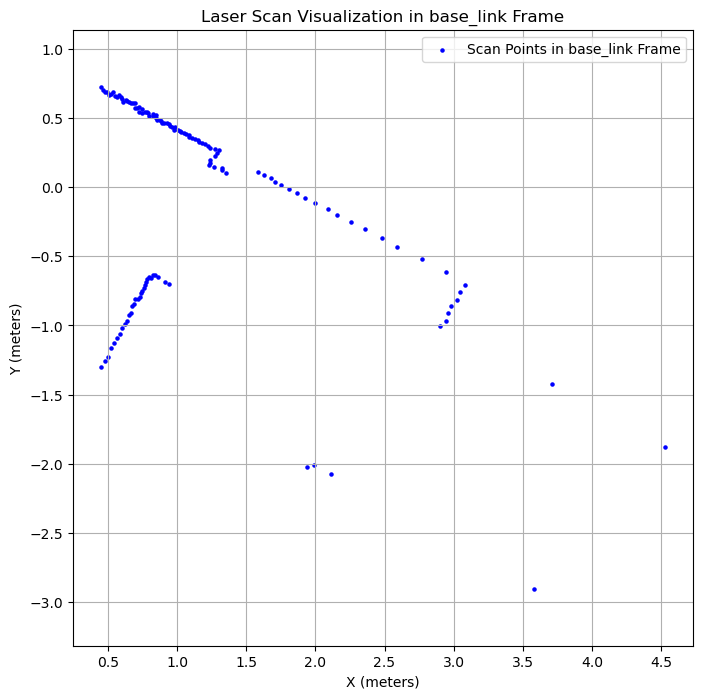

In [104]:
from tf_transformations import euler_matrix


# Create the transformation matrix from base_laser_front_link to base_link
# euler_matrix creates a 4x4 transformation matrix from roll, pitch, yaw
rotation_matrix = euler_matrix(roll, pitch, yaw)
# print(rotation_matrix.shape)
transformation_matrix = rotation_matrix
transformation_matrix[0, 3] = trans_x
transformation_matrix[1, 3] = trans_y
transformation_matrix[2, 3] = trans_z
# print(transformation_matrix.shape)
# print(np_cart.shape)


# Assume np_cart is the array of (x, y) points in the base_laser_front_link frame
# Add z=0 and homogeneous coordinate (1) to each point for matrix multiplication
num_points = np_cart.shape[0]
np_cart_homogeneous = np.hstack((np_cart, np.zeros((num_points, 1)), np.ones((num_points, 1))))
# print(np_cart_homogeneous.shape)


# Apply the transformation
np_cart_transformed = (transformation_matrix @ np_cart_homogeneous.T).T
# print(np_cart_transformed)
# Now np_cart_transformed contains the points in the base_link frame
# Extract the x and y coordinates for plotting
x_transformed = np_cart_transformed[:, 0]
y_transformed = np_cart_transformed[:, 1]
# Plot the transformed points
plt.figure(figsize=(8, 8))
plt.scatter(x_transformed, y_transformed, s=5, c='blue', label="Scan Points in base_link Frame")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Laser Scan Visualization in base_link Frame")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensures x and y scales are equal
plt.show()